
# How can we control the increasing number of accidents in New York?

The city of New York has seen a rise in the number of accidents on the roads in the city. They would like to know if the number of accidents have increased in the last few weeks. For all the reported accidents, they have collected details for each accident from January 2018 to August 2019.

The objective is to answer the following questions they would like to get answers to:

1. How have the number of accidents fluctuated over the past year and a half? Have they increased over the time?
2. For any particular day, during which hours are accidents most likely to occur?
3. Are there more accidents on weekdays than weekends?
4. What are the accidents count-to-area ratio per borough? Which boroughs have disproportionately large numbers of accidents for their size?
5. For each borough, during which hours are accidents most likely to occur?
6. What are the top 5 causes of accidents in the city? 
7. What types of vehicles are most involved in accidents per borough?
8. What types of vehicles are most involved in deaths?
9. Which areas have more accidents involving injured/killed pedestrians and cyclists

In [ ]:
!pip install geopandas

In [2]:
import json
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import base64

In [9]:
# Show the figures in the notebook as static images (For view on Github)
# Remove or comment this cell if running in a Jupyter notebook environment to see the interactive figures
!pip install --upgrade "kaleido==0.1.*"

import plotly.io as pio
pio.renderers.default = 'svg'

Analysis of the accidents-to-area ratio for boroughs. Borough data is stored in a JSON file in the ```data``` folder (this file was created using data from [Wikipedia](https://en.wikipedia.org/wiki/Boroughs_of_New_York_City)).

In [4]:
# Using json.load() to load the file borough_data.json as a dictionary.
with open('data/borough_data.json') as f:
    borough_data=json.load(f)
borough_data

{'the bronx': {'name': 'the bronx', 'population': 1471160.0, 'area': 42.1},
 'brooklyn': {'name': 'brooklyn', 'population': 2648771.0, 'area': 70.82},
 'manhattan': {'name': 'manhattan', 'population': 1664727.0, 'area': 22.83},
 'queens': {'name': 'queens', 'population': 2358582.0, 'area': 108.53},
 'staten island': {'name': 'staten island',
  'population': 479458.0,
  'area': 58.37}}

**Import the ShapeFile for Borough Boundaries**

The GIS data with the Boundaries of Boroughs for New York City is obtained from NYC Open Data. The data is provided by the Department of City Planning (DCP).
https://www.kaggle.com/datasets/skhiearth/nyc-borough-boundaries

In [5]:
geo_borough  = gpd.read_file('data/NYC Borough Boundaries/geo_export_87071461-9196-46f3-8d1b-52fed88fb835.shp')
geo_borough .head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,2.0,Bronx,1.186612e+09,462958.187332,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
1,5.0,Staten Island,1.623756e+09,325960.628294,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
2,3.0,Brooklyn,1.937593e+09,738745.840717,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
3,4.0,Queens,3.045878e+09,904188.424111,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
4,1.0,Manhattan,6.366027e+08,361212.476577,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."


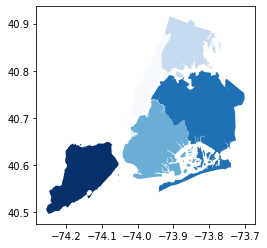

In [6]:
geo_borough.plot('boro_code', cmap='Blues') 

Importing NYC accidents dataset from .csv file

In [7]:
with open('data/accidents.csv') as f:
    df=pd.read_csv(f, delimiter=';')

df.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/26/2018,12:12,BRONX,10454.0,40.808987,-73.911316,NaN,0,0,0,...,NaN,NaN,NaN,NaN,3988123,Sedan,NaN,NaN,NaN,NaN
1,09/25/2018,16:30,BROOKLYN,11236.0,40.636005,-73.912510,FLATLANDS AVENUE,1,0,0,...,NaN,NaN,NaN,NaN,3987962,Sedan,NaN,NaN,NaN,NaN
2,08/22/2019,19:30,QUEENS,11101.0,40.755490,-73.939530,NaN,0,0,0,...,NaN,NaN,NaN,NaN,4193132,Sedan,NaN,NaN,NaN,NaN
3,09/23/2018,13:10,QUEENS,11367.0,NaN,NaN,MAIN STREET,0,0,1,...,Unspecified,NaN,NaN,NaN,3985962,Bike,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
4,08/20/2019,22:40,BRONX,10468.0,40.868336,-73.901270,NaN,0,0,0,...,Unspecified,NaN,NaN,NaN,4192111,Sedan,Sedan,NaN,NaN,NaN


## Overview of the data

Let's go through the columns present in the DataFrame:

We have the following columns:

1. **BOROUGH**: The borough in which the accident occurred
2. **COLLISION_ID**: A unique identifier for this collision
3. **CONTRIBUTING FACTOR VEHICLE (1, 2, 3, 4, 5)**: Reasons for the accident
4. **CROSS STREET NAME**: Nearest cross street to the location of the accident
5. **DATE**: Date of the accident
6. **TIME**: Time of the accident
7. **LATITUDE**: Latitude of the accident
8. **LONGITUDE**: Longitude of the accident
9. **NUMBER OF (CYCLISTS, MOTORISTS, PEDESTRIANS) INJURED**: Injuries by category
10. **NUMBER OF (CYCLISTS, MOTORISTS, PEDESTRIANS) KILLED**: Deaths by category
11. **ON STREET NAME**: Street where the accident occurred
13. **VEHICLE TYPE CODE (1, 2, 3, 4, 5)**: Types of vehicles involved in the accident
14. **ZIP CODE**: Zip code of the accident location

Since 2014, New York City has been implementing a road safety plan named [Vision Zero](https://www1.nyc.gov/content/visionzero/pages/). It aims to reduce the number of traffic deaths to *zero* by the end of 2024. The plan is creating new and enhancing current safety measures, some of these include:

<ul>
A. Automated pedestrian detection<br>
B. Road safety audits at high risk locations<br>
C. Expansion in the cycle track network<br>
D. Targeted education and awareness initiatives<br>
E. Creation of pedestrian refuge islands<br>
F. Launch Integrated Data-Driven Speed Reducer Program (speed humps & speed cushions)<br>
</ul>

Which of these initiatives could directly benefit from an analysis of the data provided?


## Exploratory Data Analysis EDA

**Accidents over time**

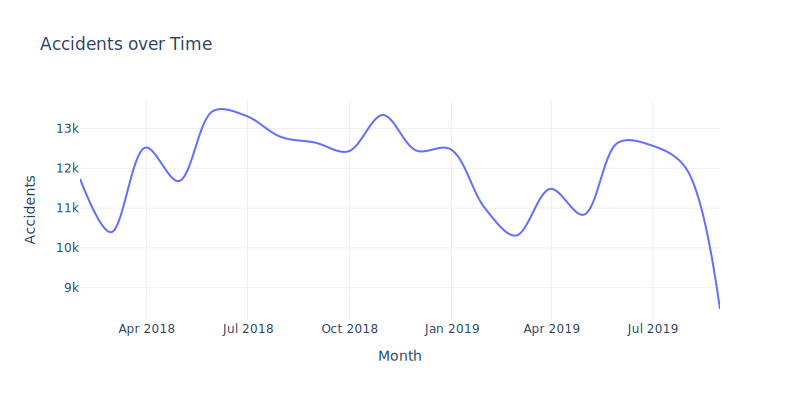

In [11]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['Month'] = df['DATE'].dt.to_period(freq = 'M')
monthly_accidents = df.groupby('Month').size()
monthly_accidents.index = monthly_accidents.index.to_timestamp(freq ='M')
monthly_accidents = monthly_accidents.reset_index(name='Accidents')
fig_ma = px.line(monthly_accidents,
                 x='Month',
                 y='Accidents',
                 template='plotly_white', #'ggplot2', 'seaborn', 'simple_white', 'plotly',
                 line_shape='spline',
                 title='Accidents over Time',
                 width=800,
                 height=400)
fig_ma

Viewed as a trend, an increase is observed until 2018-05, from then the number of accidents has been decreasing, but periods of time of increase are observed as well as others of decrease, therefore a greater analysis of the data is required to better understand this graph.

February and April and September seem to have the least number of accidents. A decrease in accidents is observed in the winter months (December to March) possibly because in winter the number of pedestrians and vehicles on the road is reduced, and a decrease is also observed in the summer season (June to September) possibly due to the lower circulation of vehicles because it is the vacation season. More context or information on the circulation of vehicles and pedestrians at different times of the year is required.

**Distribution per hour throughout the day**

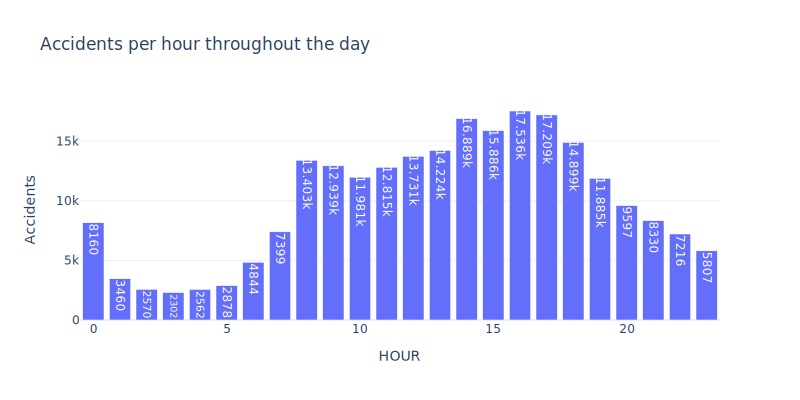

In [12]:
df['HOUR'] =  pd.to_datetime(df['TIME'], format='%H:%M').dt.hour
hourly_accidents = df.groupby('HOUR').size()
hourly_accidents = hourly_accidents.reset_index(name='Accidents')
fig_ha = px.bar(hourly_accidents,
                x='HOUR',
                y='Accidents',
                template='plotly_white',
                text_auto=True,
                title='Accidents per hour throughout the day',
                width=800,
                height=400)
fig_ha

In the graph above it can be seen that the period with the lowest accident rate is in the early morning (between 1am and 5am) and as the day progresses, accidents increase, being between 4pm and 5pm the hours with the highest accident rate in the day. This coincides with business hours and the number of vehicles traveling on the streets throughout the day.

It must be added that by not taking into account the date and place of occurrence, we could not determine a trend on certain days, such as the hours of greatest accidents on weekends and/or holidays, and we would not be able to know if more accidents occur in some areas in certain hours of the day than others.

**Accidents by day of the week**

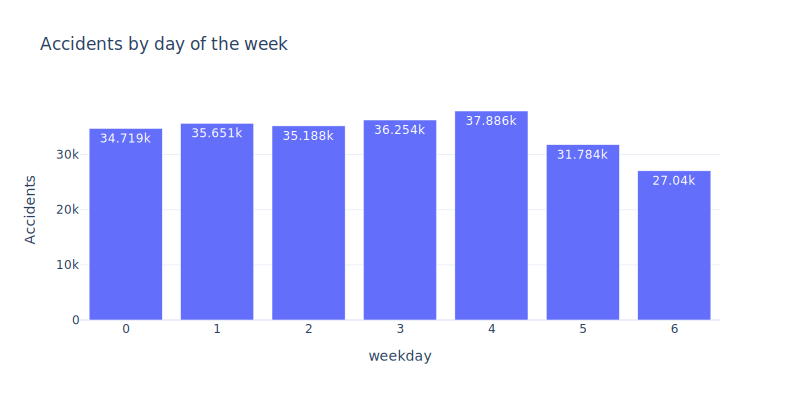

In [13]:
df['weekday'] =  pd.to_datetime(df['DATE']).dt.weekday
df['day_name'] =  pd.to_datetime(df['DATE']).dt.day_name()
weekday_accidents = df.groupby('weekday').size()
weekday_accidents = weekday_accidents.reset_index(name='Accidents')
fig_wda = px.bar(weekday_accidents,
                x='weekday',
                y='Accidents',
                template='plotly_white',
                text_auto=True,
                title='Accidents by day of the week',
                width=800,
                height=400)
fig_wda

It is observed that the day with the lowest accident rate is Sunday, since it is a rest day, not as many vehicles circulate and they do not all circulate through the same areas as on working days, and the day with the highest accident rate is observed to be Friday. although the accident rates are high on all working days

**Accidents for each borough**

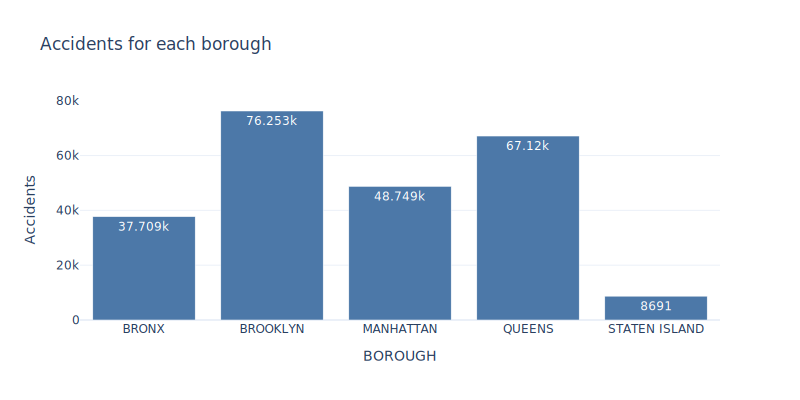

In [14]:
boroughs = df.groupby('BOROUGH').size().reset_index(name='Accidents')
fig_ba = px.bar(boroughs,
                x='BOROUGH',
                y='Accidents',
                template='plotly_white',
                text_auto=True,
                title='Accidents for each borough',
                width=800,
                height=400,
                color_discrete_sequence=px.colors.qualitative.T10)
fig_ba

In [15]:
# Using pandas.DataFrame.from_dict() to Convert JSON to DataFrame
df_borough = pd.DataFrame.from_dict(borough_data, orient="index")
df_borough = df_borough.reset_index(drop=True)

#
df_borough['name'] = df_borough['name'].str.replace('the ', '')
df_borough['name'] = df_borough['name'].str.title()
geo_borough = geo_borough.rename(columns={'boro_name': 'name'})
boroughs = boroughs.rename(columns={'BOROUGH': 'name'})
boroughs['name'] = boroughs['name'].str.title()

In [16]:
geo_borough = geo_borough.merge(df_borough, on='name')
geo_borough = geo_borough.merge(boroughs, on='name').set_index('name')
geo_borough

,boro_code,shape_area,shape_leng,geometry,population,area,Accidents
name,,,,,,,
Bronx,2.0,1.186612e+09,462958.187332,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...",1471160.0,42.10,37709
Staten Island,5.0,1.623756e+09,325960.628294,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...",479458.0,58.37,8691
Brooklyn,3.0,1.937593e+09,738745.840717,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...",2648771.0,70.82,76253
Queens,4.0,3.045878e+09,904188.424111,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ...",2358582.0,108.53,67120
Manhattan,1.0,6.366027e+08,361212.476577,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...",1664727.0,22.83,48749


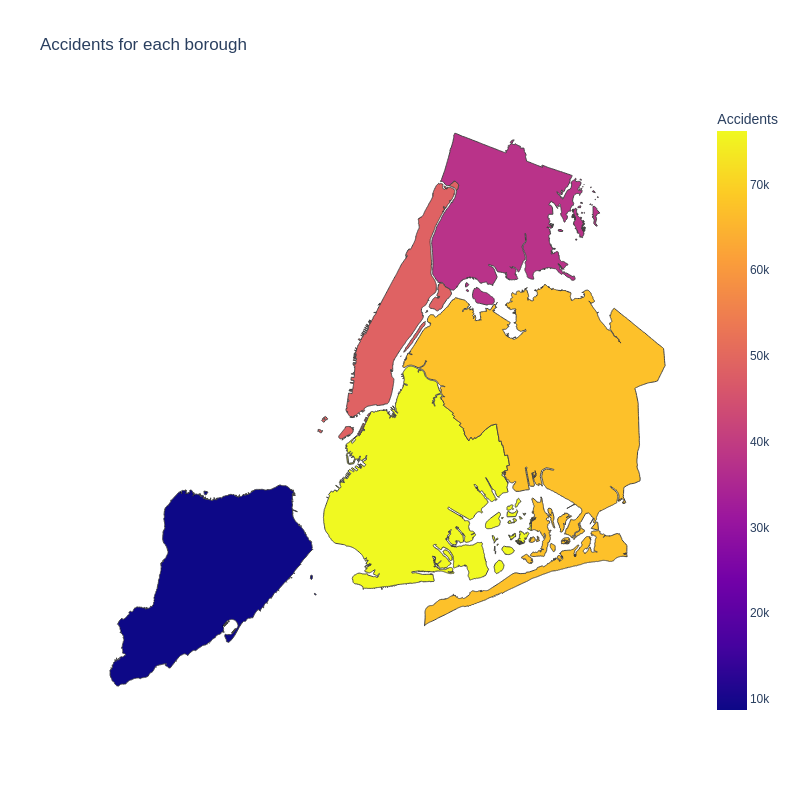

In [27]:
fig_ba2 = px.choropleth(geo_borough,
                    geojson=geo_borough.geometry,
                    locations=geo_borough.index,
                    color='Accidents',
                    projection='mercator',
                    hover_data=['population', 'area'],
                    title='Accidents for each borough',
                    width=800,
                    height=800)
fig_ba2.update_geos(fitbounds="locations", visible=False)
fig_ba2.show("png")

Manhattan is the borough with the highest number of accidents per square mile and this is because it is the borough with the smallest land area, but it is also one of the busiest borough in New York since it has the highest population density.

**Accidents per square mile for each borough**

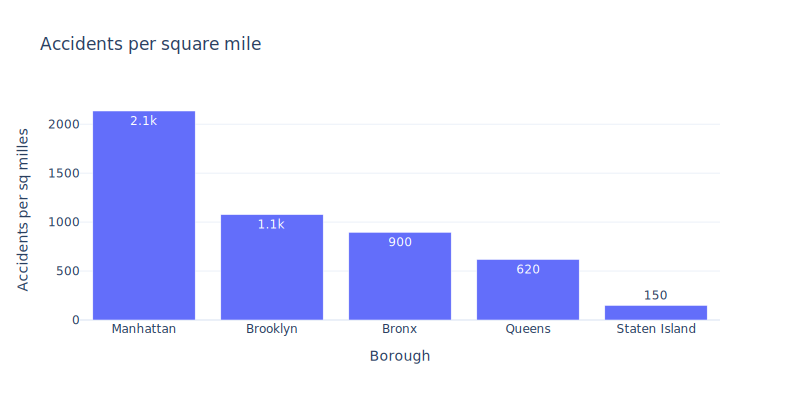

In [18]:
sq_mill_borough = geo_borough.reset_index()[['name', 'Accidents', 'area']]
sq_mill_borough['accidents_per_sq_mi'] = sq_mill_borough['Accidents'] / sq_mill_borough['area']
sq_mill_borough.sort_values('accidents_per_sq_mi', ascending=False, inplace=True)
fig_sqa = px.bar(sq_mill_borough,
                x='name',
                y='accidents_per_sq_mi',
                template='plotly_white',
                text_auto='.2s',
                labels={'name': 'Borough',
                        'accidents_per_sq_mi': 'Accidents per sq milles'},
                title='Accidents per square mile',
                width=800,
                height=400)
fig_sqa

**Accidents per hour and borough**

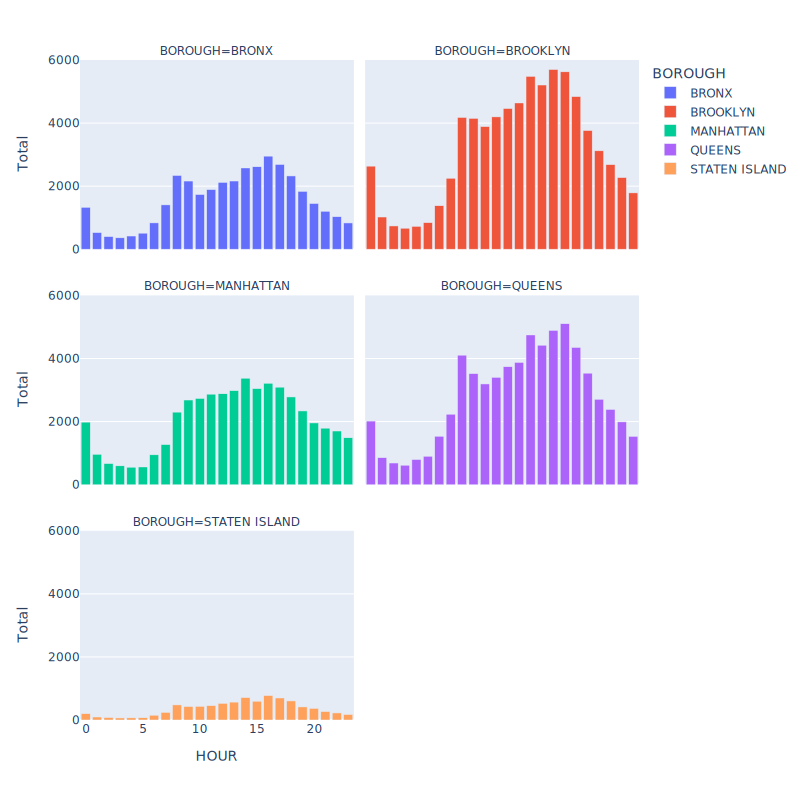

In [19]:
bor_hour = df.groupby(['BOROUGH', 'HOUR']).size().reset_index(name='Total')
fig = px.bar(bor_hour,
             x="HOUR",
             y="Total",
             color="BOROUGH",
             facet_col="BOROUGH",
             facet_col_wrap=2,
             width=800,
             height=800)
fig

The hours with the highest accident rate in all boroughs are during working hours from 8 am to 6 pm, with all the boroughs having the highest accident rate in the afternoon hours. For the Bronx, there is a higher accident rate between 8 and 9 am and at 4 pm. Brooklyn has its highest accident rate between the hours of 2 pm and 5 pm. Manhattan has its peak accident hour at 2 pm. The borough of Queens has the highest accident rate at 8 am in the morning and 5 pm in the afternoon, and for the borough of Staten Island the hour with the highest accident rate is 4 pm.

**Top factors which cause the most accidents**

In [20]:
contrib_df = df[['COLLISION_ID','CONTRIBUTING FACTOR VEHICLE 1',
    'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
    'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5']].copy()
contrib_df = pd.melt(contrib_df, id_vars =['COLLISION_ID'], value_vars =['CONTRIBUTING FACTOR VEHICLE 1',
    'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
    'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5'], 
    var_name ='CONTRIBUTING FACTOR', value_name ='Cause')
contrib_df.dropna(inplace=True)
factors_most_acc = (contrib_df.groupby('Cause')['COLLISION_ID'].unique()
                    .explode()
                    .reset_index(name='index'))
factors_most_acc = (factors_most_acc.groupby('Cause').count()
                    .sort_values('index', ascending=False)
                    .head(6))
factors_most_acc

,index
Cause,
Unspecified,190096
Driver Inattention/Distraction,61752
Failure to Yield Right-of-Way,19641
Following Too Closely,17293
Backing Unsafely,14835
Passing Too Closely,12631


**Top 10 vehicle type-borough pairs which are most involved in accidents**

In [21]:
vehi_cols = ['VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5']
vehi_most_acc = df[['BOROUGH', 'COLLISION_ID'] + vehi_cols].copy()
vehi_most_acc = pd.melt(vehi_most_acc, id_vars=['BOROUGH', 'COLLISION_ID'], value_vars=vehi_cols, value_name ='car_type')
vehi_most_acc.dropna(inplace=True)
vehi_most_acc = (vehi_most_acc.groupby(['BOROUGH', 'car_type'])['COLLISION_ID'].unique()
                  .explode()
                  .reset_index(name='index'))
vehi_most_acc = (vehi_most_acc.groupby(['BOROUGH', 'car_type']).count()
                  .sort_values('index', ascending=False)
                  .head(10))
vehi_most_acc

,,index
BOROUGH,car_type,
BROOKLYN,Sedan,39459
QUEENS,Sedan,35103
BROOKLYN,Station Wagon/Sport Utility Vehicle,32262
QUEENS,Station Wagon/Sport Utility Vehicle,31647
MANHATTAN,Sedan,20727
BRONX,Sedan,19652
MANHATTAN,Station Wagon/Sport Utility Vehicle,16432
BRONX,Station Wagon/Sport Utility Vehicle,15434
BROOKLYN,PASSENGER VEHICLE,10177


**Number of deaths caused by each type of vehicle**

In [22]:
kill_cols = ['NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED']
filtered_df = df[['COLLISION_ID'] + kill_cols + vehi_cols].copy()
filtered_df['kills'] = df['NUMBER OF PEDESTRIANS KILLED'] + df['NUMBER OF CYCLIST KILLED'] + df['NUMBER OF MOTORIST KILLED']
filtered_df = filtered_df[filtered_df['kills'] > 0]
top_vehi = pd.melt(filtered_df, id_vars=['COLLISION_ID', 'kills'], value_vars=vehi_cols, value_name ='vehicle_type')
top_vehi.dropna(inplace=True)
top_vehi = (top_vehi.groupby(['COLLISION_ID', 'kills'])['vehicle_type'].unique()
            .explode()
            .reset_index())
top_vehi = top_vehi.groupby(['vehicle_type'])['kills'].sum()
top_vehi = top_vehi.reset_index(name='TOTAL KILLED')
top_vehi = top_vehi.sort_values('TOTAL KILLED', ascending=False)
top_vehi.head()

,vehicle_type,TOTAL KILLED
25,Station Wagon/Sport Utility Vehicle,87
23,Sedan,65
16,Motorcycle,22
19,PASSENGER VEHICLE,21
22,SPORT UTILITY / STATION WAGON,20


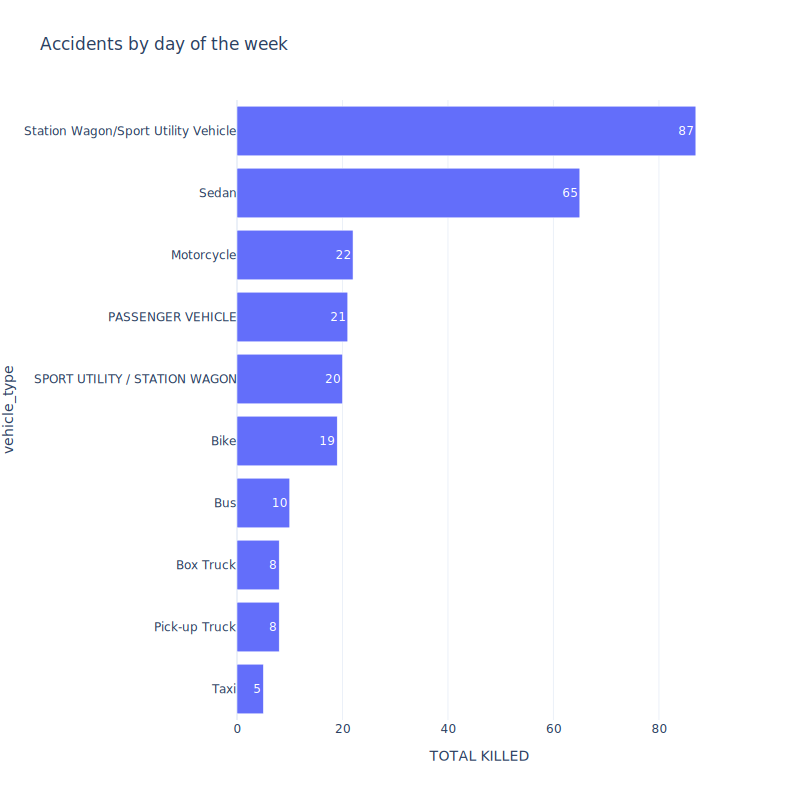

In [23]:
fig_ka = px.bar(top_vehi.head(10),
                x='TOTAL KILLED',
                y='vehicle_type',
                template='plotly_white',
                text_auto=True,
                orientation='h',
                title='Accidents by day of the week',
                width=800,
                height=800)
fig_ka.update_layout(yaxis=dict(autorange="reversed"))
fig_ka

The vehicles that are most frequently involved in deaths, and by far more than the others, are:

*   Station Wagon/Sport Utility Vehicle
*   Sedan

**Heatmap of the accidents involving injured/killed pedestrians and cyclists**

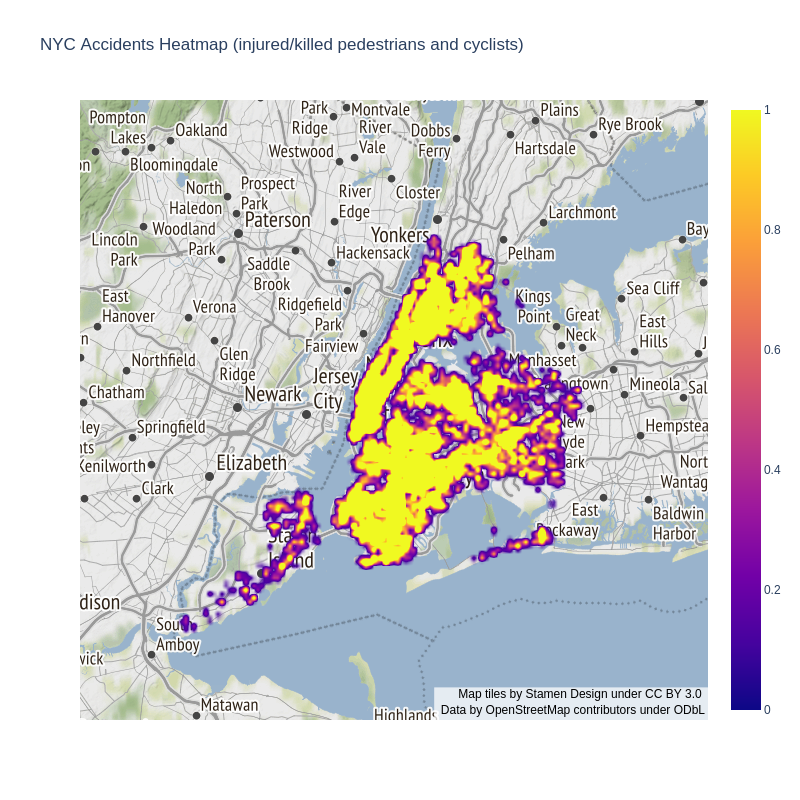

In [28]:
 df_heatmap = df[['BOROUGH', 'LATITUDE', 'LONGITUDE',
                 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED',
                 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED']].copy()

df_heatmap['KILLED'] = df_heatmap['NUMBER OF PEDESTRIANS KILLED'] + df_heatmap['NUMBER OF CYCLIST KILLED']
df_heatmap['INJURED'] = df_heatmap['NUMBER OF PEDESTRIANS INJURED'] + df_heatmap['NUMBER OF PEDESTRIANS INJURED']
df_heatmap = df_heatmap[(df_heatmap['KILLED'] > 0) | (df_heatmap['INJURED'] > 0)]

fig_heat = px.density_mapbox(df_heatmap, lat='LATITUDE', lon='LONGITUDE', radius=4,
                        center=dict(lat=40.73352, lon=-73.95725), zoom=9,
                        title='NYC Accidents Heatmap (injured/killed pedestrians and cyclists)',
                        width=800, height=800,
                        mapbox_style="stamen-terrain")
fig_heat.show("png")

The heat map shows the concentration of accidents involving injured/dead pedestrians and cyclists. In critical areas, the type of factors involved in accidents should be studied in order to later give a recommendation to visit these areas and further study the problem.